In [1]:
import earthchem
%matplotlib inline

earthchem.__version__

'0.0.4+1.g83744cf.dirty'

Make a rest client

In [2]:
q = earthchem.Query(author='klump')
q.url

'http://ecp.iedadata.org/restsearchservice?outputtype=json&author=klump'

How many records have we found?

In [3]:
q.count()

0

In [4]:
q.dataframe()

Didn't find any records for this query, returning None


Let's try another author

In [17]:
q = earthchem.Query(
    author='barnes+s',
    geologicalage='archean'
)
q.count()

876

Get the first 50 records

In [13]:
df = q.dataframe()

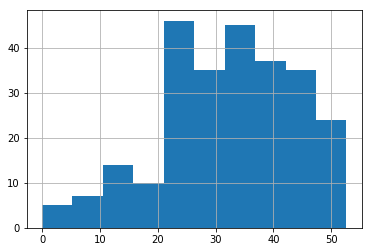

In [14]:
df.mgo.hist()

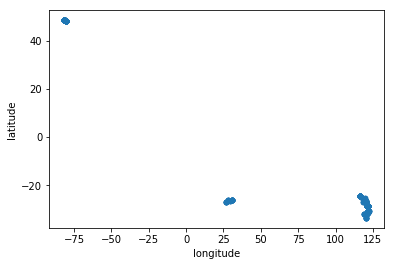

In [15]:
df.plot('longitude', 'latitude', 'scatter')

Now we can generate a plot of this data

In [ ]:
%matplotlib inline

df.plot('longitude', 'latitude', 'scatter')

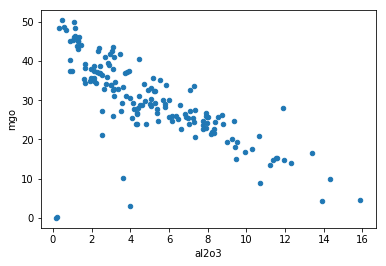

In [16]:
df.plot('al2o3', 'mgo', 'scatter')